In [1]:
import os
import time as timer
import copy

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import numpy as np

from sklearn.preprocessing import MinMaxScaler

from torchvision import datasets
import torchvision.transforms as T

from joblib import dump, load

In [2]:
from vae import VAE_v2
import train_utils as tu
import visualization_utils as vu

## Define Constants

In [3]:
DATA_DIR = './data'
MODEL_DIR = './models'

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Load Data

In [4]:
training_data = load('./data/training_subdata.bin')
training_data

Dataset MNIST
    Number of datapoints: 5000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=T.ToTensor(), #convert to Tensor and normalize to (0, 1)
)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
"""
Create data loaders
"""
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

## Extract Encoder from Pre-trained Autoencoder

In [8]:
"""Load pre-trained autoencoder"""
print(f"Using {DEVICE} device")

# Define model
model = VAE_v2().to(DEVICE)

model_path = os.path.join(MODEL_DIR, "uns_vae_v2_mnist.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cuda device
VAE_v2(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=150, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [9]:
pretrained_vae = copy.deepcopy(model)
pretrained_vae

VAE_v2(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=150, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

## Define SSL with AE Model

In [10]:
classifier_layer = nn.Sequential(
    nn.ReLU(),
    nn.Linear(150 * 2, 10)
)

pretrained_vae.add_module('classifier_layer', classifier_layer)

In [11]:
def forward(self, x):
    z = self.encoder(x)
    out = self.classifier_layer(z)
    return out

VAE_v2.forward = forward

In [12]:
pretrained_vae

VAE_v2(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=150, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (classifier_layer): Sequential(
    (0): ReLU()
    (1): Linear(in_features=300, out_features=10, bias=True)
  )
)

# Train SSL AE Model

In [13]:
print(f"Using {DEVICE} device")

# Define model
pretrained_vae = pretrained_vae.to(DEVICE)
print(pretrained_vae)

# Persistent file to store the model
model_path = os.path.join(MODEL_DIR, "ssl_vae_v2_mnist.pth")

Using cuda device
VAE_v2(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=150, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
  (classifier_layer): Sequential(
    (0): ReLU()
    (1): Linear(in_features=300, out_features=10, bias=True)
  )
)


### Define the Loss Function and the Optimizer

In [14]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    pretrained_vae.parameters(), 
    lr=LEARNING_RATE
)

### Execute the Training

In [15]:
test_accuracy = []
train_accuracy = []
for t in range(EPOCHS):
    print(f"Epoch {t+1} out of {EPOCHS}\n ------------")
    
    start = timer.time()
    tu.train_ssl(train_dl, pretrained_vae, loss_fn, optimizer)
    elapsed_time = timer.time() - start # this timing method ONLY works for CPU computation, not for GPU/cuda calls
    print(f" > Training time: {elapsed_time:>.2f} seconds")
    
    print("Test Set Error:")
    acc_test = tu.test_ssl(test_dl, pretrained_vae, loss_fn)
    print("\nTrain Set Error:")
    acc_train = tu.test_ssl(train_dl, pretrained_vae, loss_fn)
    test_accuracy.append(acc_test)
    train_accuracy.append(acc_train)
    
    # Save model
    torch.save(pretrained_vae.state_dict(), model_path)
    print(f"Model {model_path} stored!")
    
print("Done!")

Epoch 1 out of 100
 ------------
Loss: 2.179495 [    0]/ 5000
Loss: 2.498253 [ 1600]/ 5000
Loss: 2.347577 [ 3200]/ 5000
Loss: 2.399682 [ 4800]/ 5000
 > Training time: 1.79 seconds
Test Set Error:
Test Error: 
 Accuracy: 24.9%, Avg loss: 2.258398 


Train Set Error:
Test Error: 
 Accuracy: 23.5%, Avg loss: 2.261238 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 2 out of 100
 ------------
Loss: 2.147679 [    0]/ 5000
Loss: 2.441299 [ 1600]/ 5000
Loss: 2.266698 [ 3200]/ 5000
Loss: 2.339708 [ 4800]/ 5000
 > Training time: 0.99 seconds
Test Set Error:
Test Error: 
 Accuracy: 58.8%, Avg loss: 2.171214 


Train Set Error:
Test Error: 
 Accuracy: 57.7%, Avg loss: 2.173091 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 3 out of 100
 ------------
Loss: 2.074904 [    0]/ 5000
Loss: 2.373723 [ 1600]/ 5000
Loss: 2.162076 [ 3200]/ 5000
Loss: 2.265305 [ 4800]/ 5000
 > Training time: 0.99 seconds
Test Set Error:
Test Error: 
 Accuracy: 74.6%, Avg loss: 2.059418 


Train Set Error:
Test Error

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.397268 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 24 out of 100
 ------------
Loss: 0.227260 [    0]/ 5000
Loss: 0.855477 [ 1600]/ 5000
Loss: 0.238482 [ 3200]/ 5000
Loss: 0.594723 [ 4800]/ 5000
 > Training time: 1.00 seconds
Test Set Error:
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.406948 


Train Set Error:
Test Error: 
 Accuracy: 91.3%, Avg loss: 0.382088 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 25 out of 100
 ------------
Loss: 0.213506 [    0]/ 5000
Loss: 0.832479 [ 1600]/ 5000
Loss: 0.228211 [ 3200]/ 5000
Loss: 0.563049 [ 4800]/ 5000
 > Training time: 1.07 seconds
Test Set Error:
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.394143 


Train Set Error:
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.368256 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 26 out of 100
 ------------
Loss: 0.200883 [    0]/ 5000
Loss: 0.810556 [ 1600]/ 5000
Loss: 0.218915 [ 3200]/ 5000
Loss: 0.533833 [ 4800]/ 5000
 > Training time: 1.01 secon

Loss: 0.231286 [ 4800]/ 5000
 > Training time: 1.12 seconds
Test Set Error:
Test Error: 
 Accuracy: 92.3%, Avg loss: 0.261893 


Train Set Error:
Test Error: 
 Accuracy: 94.3%, Avg loss: 0.217671 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 47 out of 100
 ------------
Loss: 0.065957 [    0]/ 5000
Loss: 0.521305 [ 1600]/ 5000
Loss: 0.123739 [ 3200]/ 5000
Loss: 0.224077 [ 4800]/ 5000
 > Training time: 1.06 seconds
Test Set Error:
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.258631 


Train Set Error:
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.213620 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 48 out of 100
 ------------
Loss: 0.063073 [    0]/ 5000
Loss: 0.512561 [ 1600]/ 5000
Loss: 0.121578 [ 3200]/ 5000
Loss: 0.217293 [ 4800]/ 5000
 > Training time: 1.15 seconds
Test Set Error:
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.255502 


Train Set Error:
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.209704 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 49 out of 100
 -----------

Loss: 0.381935 [ 1600]/ 5000
Loss: 0.089763 [ 3200]/ 5000
Loss: 0.130412 [ 4800]/ 5000
 > Training time: 1.22 seconds
Test Set Error:
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.210197 


Train Set Error:
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.148799 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 70 out of 100
 ------------
Loss: 0.027384 [    0]/ 5000
Loss: 0.377510 [ 1600]/ 5000
Loss: 0.088595 [ 3200]/ 5000
Loss: 0.127829 [ 4800]/ 5000
 > Training time: 1.07 seconds
Test Set Error:
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.208714 


Train Set Error:
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.146592 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 71 out of 100
 ------------
Loss: 0.026503 [    0]/ 5000
Loss: 0.373313 [ 1600]/ 5000
Loss: 0.087438 [ 3200]/ 5000
Loss: 0.125357 [ 4800]/ 5000
 > Training time: 1.06 seconds
Test Set Error:
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.207262 


Train Set Error:
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.144424 

Model ./models\ssl

Loss: 0.299899 [ 1600]/ 5000
Loss: 0.067634 [ 3200]/ 5000
Loss: 0.086739 [ 4800]/ 5000
 > Training time: 1.15 seconds
Test Set Error:
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.184048 


Train Set Error:
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.106644 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 93 out of 100
 ------------
Loss: 0.014433 [    0]/ 5000
Loss: 0.297055 [ 1600]/ 5000
Loss: 0.066753 [ 3200]/ 5000
Loss: 0.085380 [ 4800]/ 5000
 > Training time: 1.08 seconds
Test Set Error:
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.183212 


Train Set Error:
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.105137 

Model ./models\ssl_vae_v2_mnist.pth stored!
Epoch 94 out of 100
 ------------
Loss: 0.014102 [    0]/ 5000
Loss: 0.294209 [ 1600]/ 5000
Loss: 0.065984 [ 3200]/ 5000
Loss: 0.084059 [ 4800]/ 5000
 > Training time: 1.07 seconds
Test Set Error:
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.182393 


Train Set Error:
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.103650 

Model ./models\ssl

## Accuracy Plot

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Plotting Helper Function
def plot_acc_epoch(epochs, train_acc, test_acc):
    l = range(1,epochs+1)
    N = len(l)
    l2 = np.arange(N)
    plt.subplots(figsize=(10, 5))
    plt.plot(l2, test_acc, label="Testing Accuracy")
    plt.plot(l2, train_acc, label="Training Accuracy")
#     plt.xticks(l2,l)
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title('Accuracy versus Epoch SSL with VAE Model Model', fontsize=12)
    plt.show()

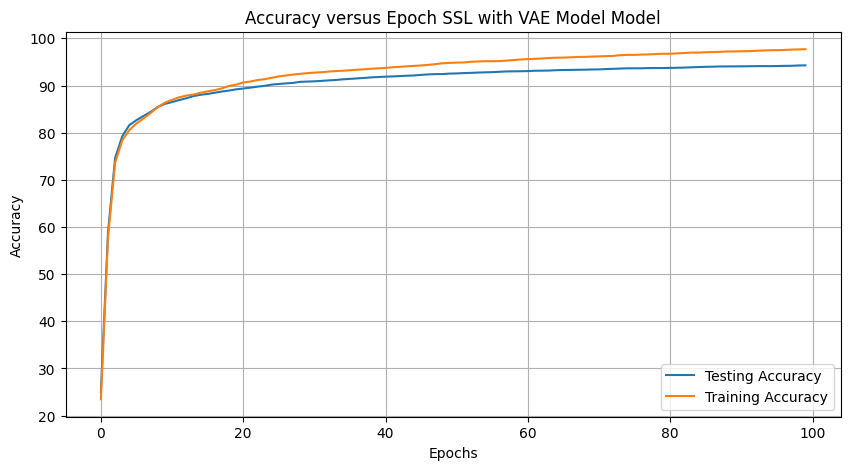

In [18]:
plot_acc_epoch(100, train_accuracy, test_accuracy)

In [19]:
max(train_accuracy), max(test_accuracy)

(97.7, 94.28)

In [20]:
train_accuracy[-1], test_accuracy[-1]

(97.7, 94.28)